In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
df_loan = pd.read_csv('data/loan_train.csv')

df_loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Удаляем столбец Loan_ID, его значения уникальны, а значит никак не помогут классификации.
df_loan = df_loan.drop('Loan_ID', axis=1)

df_loan.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## EDA

In [4]:
df_loan.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
df_loan.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

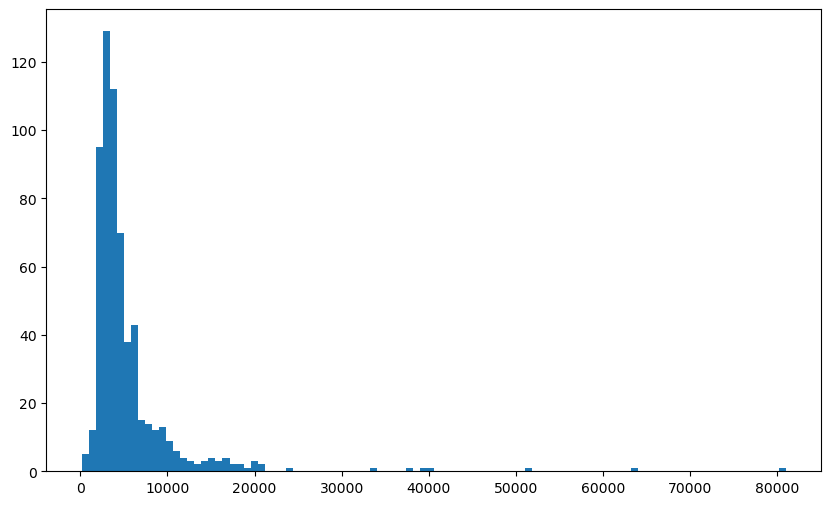

In [6]:
_, ax = plt.subplots(figsize=(10,6))
ax.hist(df_loan['ApplicantIncome'], bins=100)
plt.show()

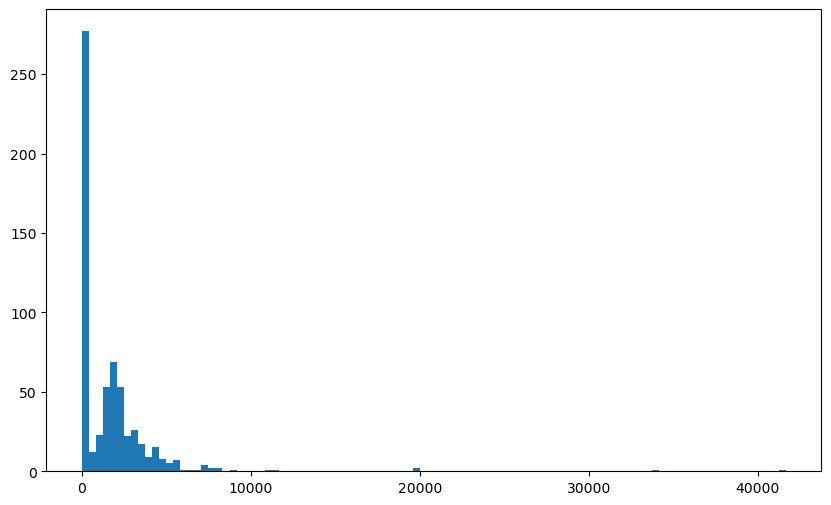

In [7]:
_, ax = plt.subplots(figsize=(10,6))
ax.hist(df_loan['CoapplicantIncome'], bins=100)
plt.show()

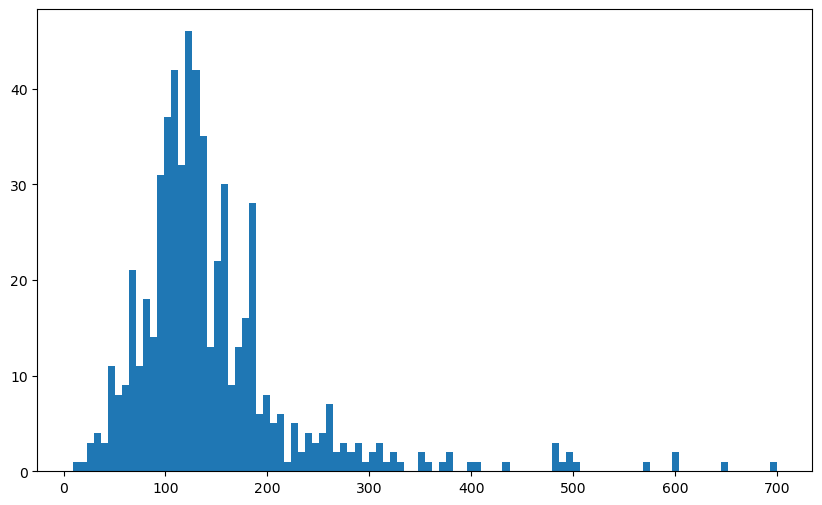

In [8]:
_, ax = plt.subplots(figsize=(10,6))
ax.hist(df_loan['LoanAmount'], bins=100)
plt.show()

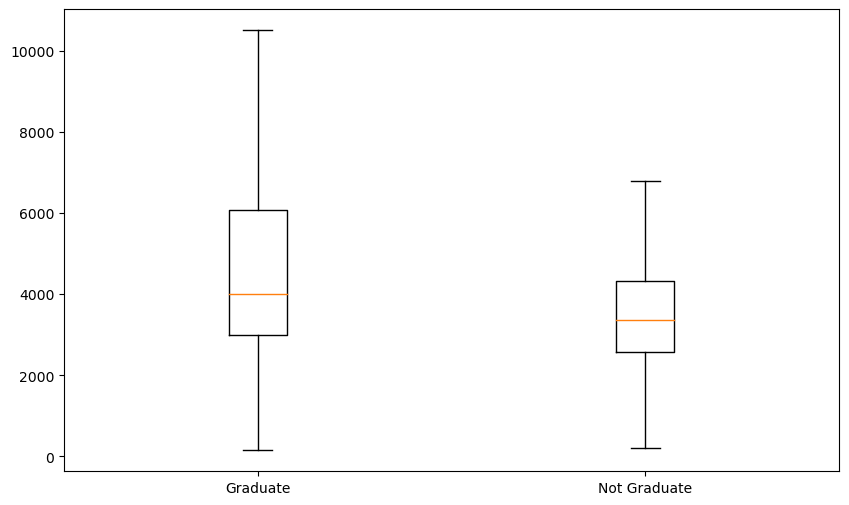

In [9]:
_, ax = plt.subplots(figsize=(10,6))

ax.boxplot(
    [
        df_loan[df_loan['Education'] == 'Graduate']['ApplicantIncome'],
        df_loan[df_loan['Education'] == 'Not Graduate']['ApplicantIncome'],
    ], 
    labels = [
        'Graduate',
        'Not Graduate'
    ],
    showfliers=False)

plt.show()

In [10]:
# Сводная таблица вычислит сколько 'Y' и N' в колонке Loan_Status 
# для групп с разными значениеми в колонке Credit_History
df_pivot = df_loan.pivot_table(index='Credit_History', columns='Loan_Status', aggfunc='size')

# Переведем все в проценты
df_pivot.iloc[0] = df_pivot.iloc[0]/df_pivot.iloc[0].sum()
df_pivot.iloc[1] = df_pivot.iloc[1]/df_pivot.iloc[1].sum()

df_pivot

Loan_Status,N,Y
Credit_History,,
0.0,0.921348,0.078652
1.0,0.204211,0.795789


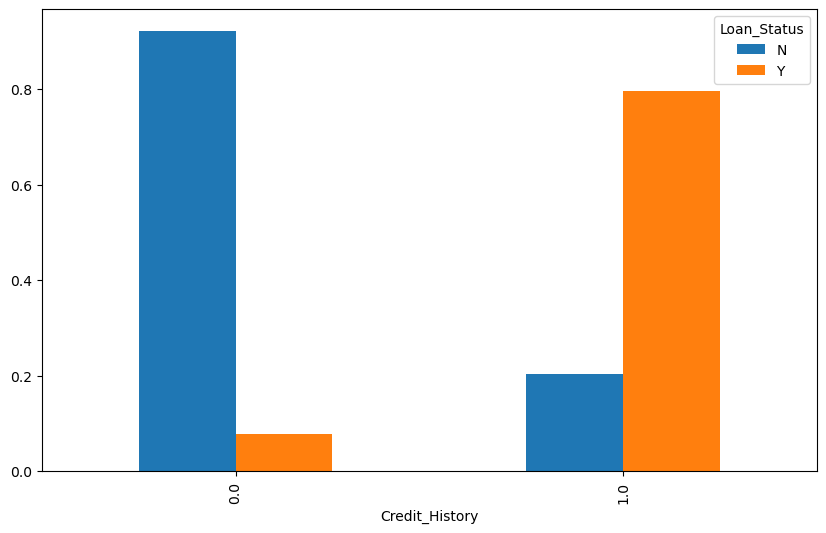

In [11]:
df_pivot.plot(kind='bar', figsize=(10,6))
plt.show()

## Data Preparation

In [12]:
df_pred = df_loan.copy()

df_label = df_pred['Loan_Status'].apply(lambda x: 1.0 if x == 'Y' else 0.0)

df_pred.drop('Loan_Status', axis=1, inplace=True)

Анализ данных показал, что в наборе данных есть пропущенные значения. Чтобы заполнить пропуски в категориальных признаках, мы будем использовать моду. А для числовых признаков применим медиану.

In [13]:
numerical = df_pred.select_dtypes(include=['int64', 'float64']).columns

categorical = df_pred.select_dtypes(include=['object']).columns

print(numerical)
print(categorical)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')


In [14]:
for feat in categorical:
    df_pred[feat].fillna(df_pred[feat].mode()[0], inplace=True)
    
for feat in numerical:
    df_pred[feat].fillna(df_pred[feat].median(), inplace=True)

# Убедимся, что пропущенных значений больше нет
df_pred.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

## Standardization and normalization

In [15]:
df_onehot = pd.get_dummies(df_pred[categorical])

df_onehot.head()

,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
2,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1
3,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1


In [16]:
# Удалим оригинальные категориальные признаки
df_pred.drop(categorical, axis=1, inplace=True)

df_pred = pd.concat([df_pred, df_onehot], axis=1)

In [17]:
scaler = StandardScaler()

df_pred = scaler.fit_transform(df_pred)

 ## Modeling

In [18]:
X = df_pred
y = df_label

Протестируем три модели: логистическую регрессию, случайный лес и многослойный персептрон. 

In [19]:
models = [
    LogisticRegression(solver='liblinear'),
    RandomForestClassifier(),
    MLPClassifier(activation='logistic', hidden_layer_sizes = (256,128,64))
]

for m in models:
    score = cross_val_score(m, X, y, cv=4, scoring='accuracy')
    print(f'model: {type(m).__name__}, acc_mean: {score.mean():.4f}, acc_std: {score.std():.4f}')

model: LogisticRegression, acc_mean: 0.8014, acc_std: 0.0169
model: RandomForestClassifier, acc_mean: 0.7850, acc_std: 0.0103
model: MLPClassifier, acc_mean: 0.7965, acc_std: 0.0256
